In [1]:
import os
import time
import progressbar
import matplotlib.pyplot as plt
import tensorflow as tf
# Remove the line that imports tensorflow_backend from keras.backend
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
from tensorflow.keras.preprocessing.image import load_img  # Change keras.preprocessing to tensorflow.keras.preprocessing
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")



In [2]:
dir_Flickr_text = "flickr30k-images/Flickr8k.token.txt"
dir_Flickr_jpg = "flickr30k-images"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker30k: {}".format(len(jpgs)))

The number of jpg flies in Flicker30k: 31787


In [28]:
def load_csv(directory):
    with open(directory, 'r') as file:
        data = file.readlines()

    datatxt = []
    for line in data:
        # Split each line by the first occurrence of '\t' to separate filename and caption
        tokens = line.strip().split('\t', 1)
        if len(tokens) == 2:
            filename, caption = tokens
            filename = filename.split('#')[0]  # Split to remove the caption index
            datatxt.append([filename, caption])

    # Create a DataFrame
    df_txt = pd.DataFrame(datatxt, columns=["filename", "caption"])
    return df_txt

# Load the data
df_txt = load_csv(dir_Flickr_text)

# Processing to find unique filenames and their distribution
uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
print(Counter(df_txt.filename.values))

The number of unique file names : 31783
The distribution of the number of captions for each image:
Counter({'1000092795.jpg': 5, '10002456.jpg': 5, '1000268201.jpg': 5, '1000344755.jpg': 5, '1000366164.jpg': 5, '1000523639.jpg': 5, '1000919630.jpg': 5, '10010052.jpg': 5, '1001465944.jpg': 5, '1001545525.jpg': 5, '1001573224.jpg': 5, '1001633352.jpg': 5, '1001773457.jpg': 5, '1001896054.jpg': 5, '100197432.jpg': 5, '100207720.jpg': 5, '1002674143.jpg': 5, '1003163366.jpg': 5, '1003420127.jpg': 5, '1003428081.jpg': 5, '100444898.jpg': 5, '1005216151.jpg': 5, '100577935.jpg': 5, '1006452823.jpg': 5, '100652400.jpg': 5, '1007129816.jpg': 5, '100716317.jpg': 5, '1007205537.jpg': 5, '1007320043.jpg': 5, '100759042.jpg': 5, '10082347.jpg': 5, '10082348.jpg': 5, '100845130.jpg': 5, '10090841.jpg': 5, '1009434119.jpg': 5, '1009692167.jpg': 5, '101001624.jpg': 5, '1010031975.jpg': 5, '1010087179.jpg': 5, '1010087623.jpg': 5, '10101477.jpg': 5, '1010470346.jpg': 5, '1010673430.jpg': 5, '101093029

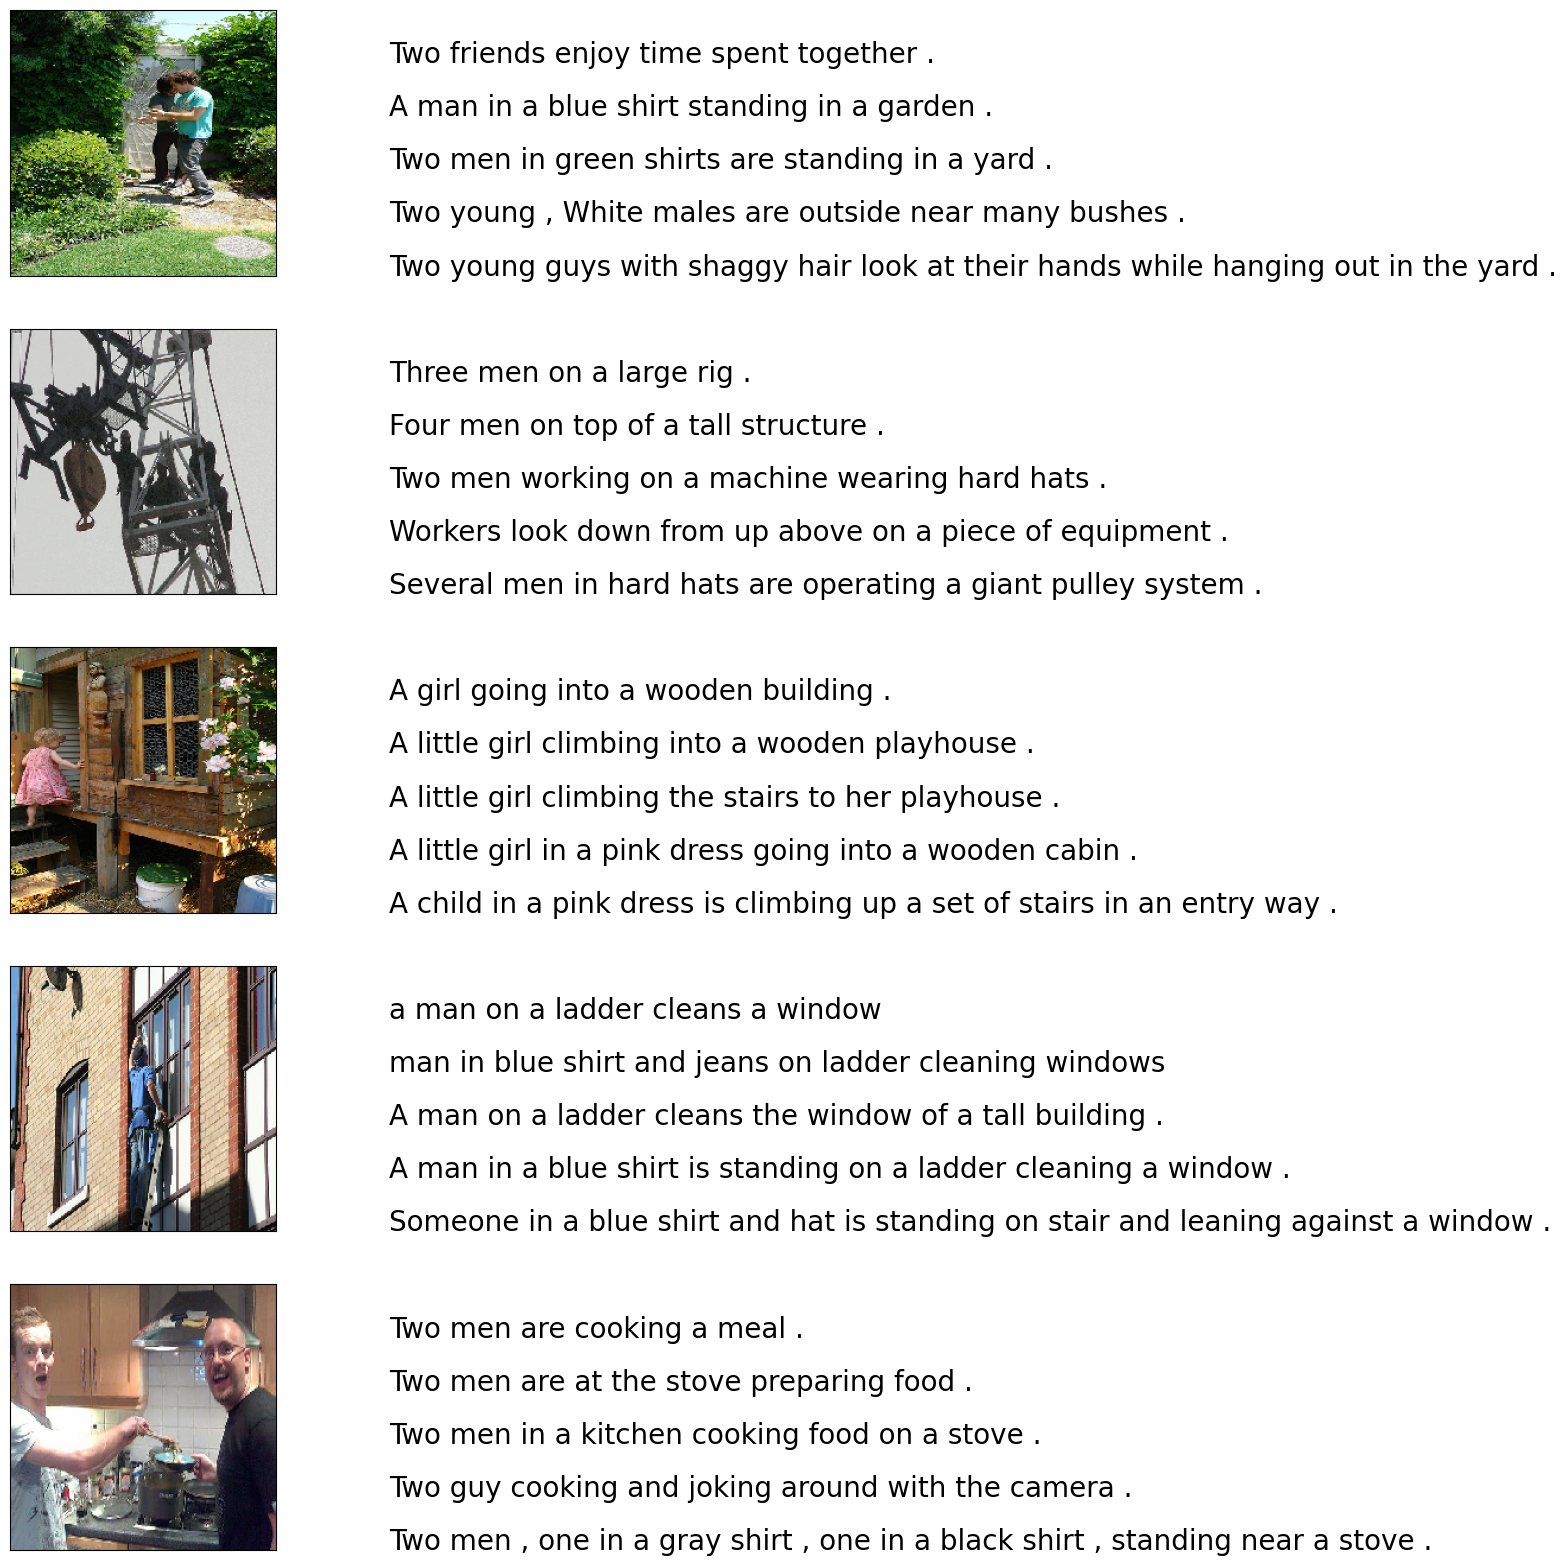

In [29]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [8]:
df_txt

filename                                            caption
0       1000092795.jpg  Two young guys with shaggy hair look at their ...
1       1000092795.jpg  Two young , White males are outside near many ...
2       1000092795.jpg   Two men in green shirts are standing in a yard .
3       1000092795.jpg       A man in a blue shirt standing in a garden .
4       1000092795.jpg            Two friends enjoy time spent together .
...                ...                                                ...
158910   998845445.jpg  A man in shorts and a Hawaiian shirt leans ove...
158911   998845445.jpg  A young man hanging over the side of a boat , ...
158912   998845445.jpg  A man is leaning off of the side of a blue and...
158913   998845445.jpg  A man riding a small boat in a harbor , with f...
158914   998845445.jpg  A man on a moored blue and white boat with hil...

[158915 rows x 2 columns]

In [15]:
df_txt.iloc[i]


filename                             1000092795.jpg
caption     Two friends enjoy time spent together .
Name: 4, dtype: object

In [36]:
def df_word(df_txt):
    vocabulary = []
    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,1]
        vocabulary.extend(temp)
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 86


word    count
0       1968867
1    a   792209
2    e   749145

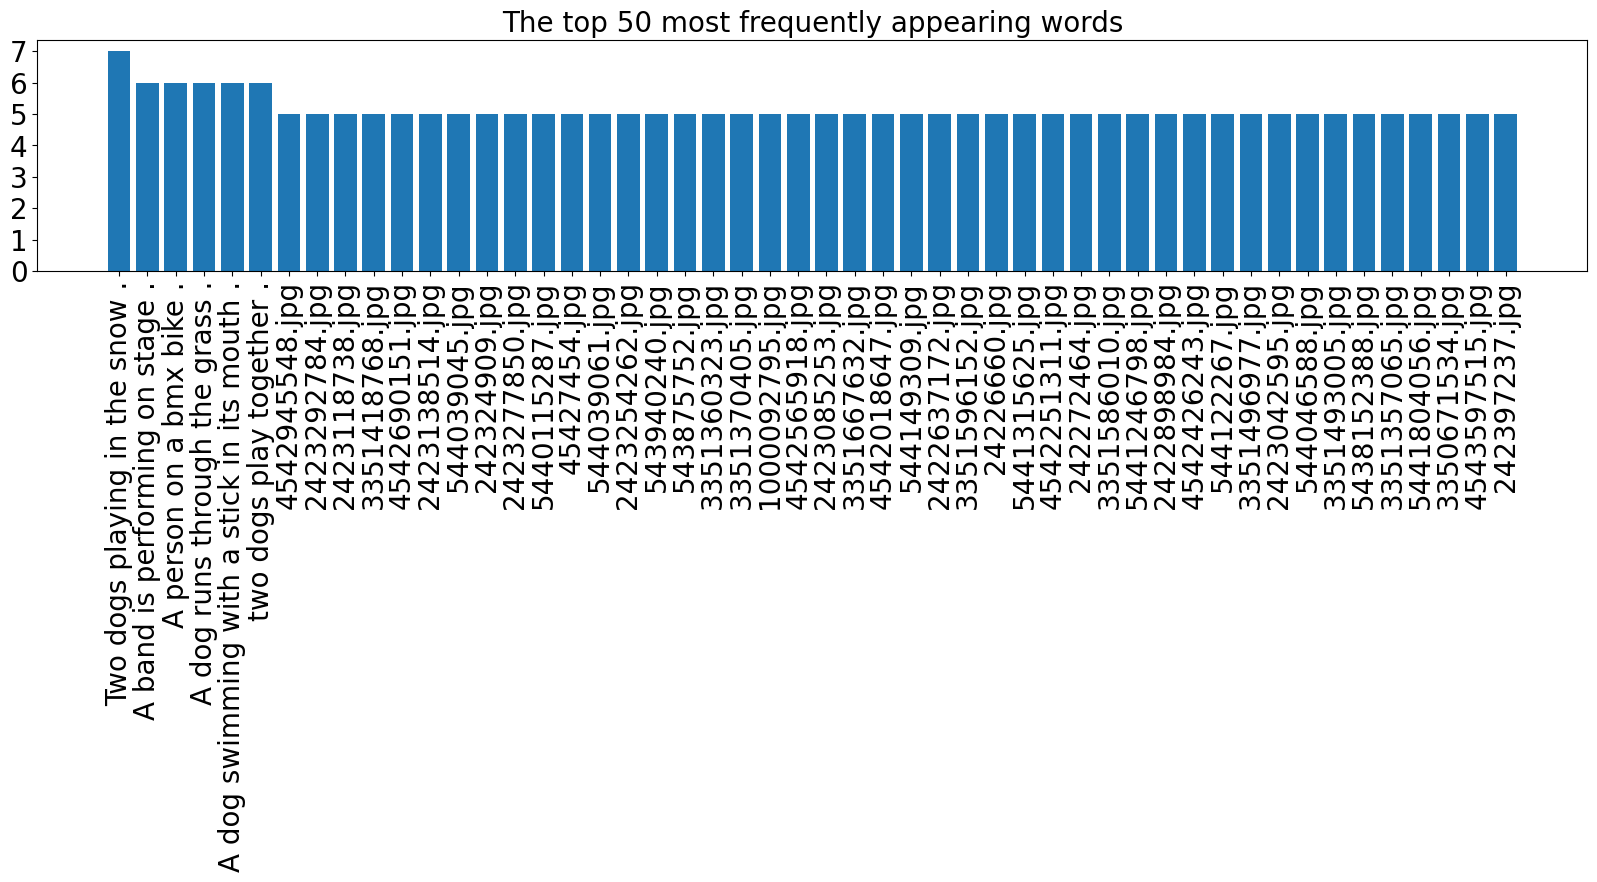

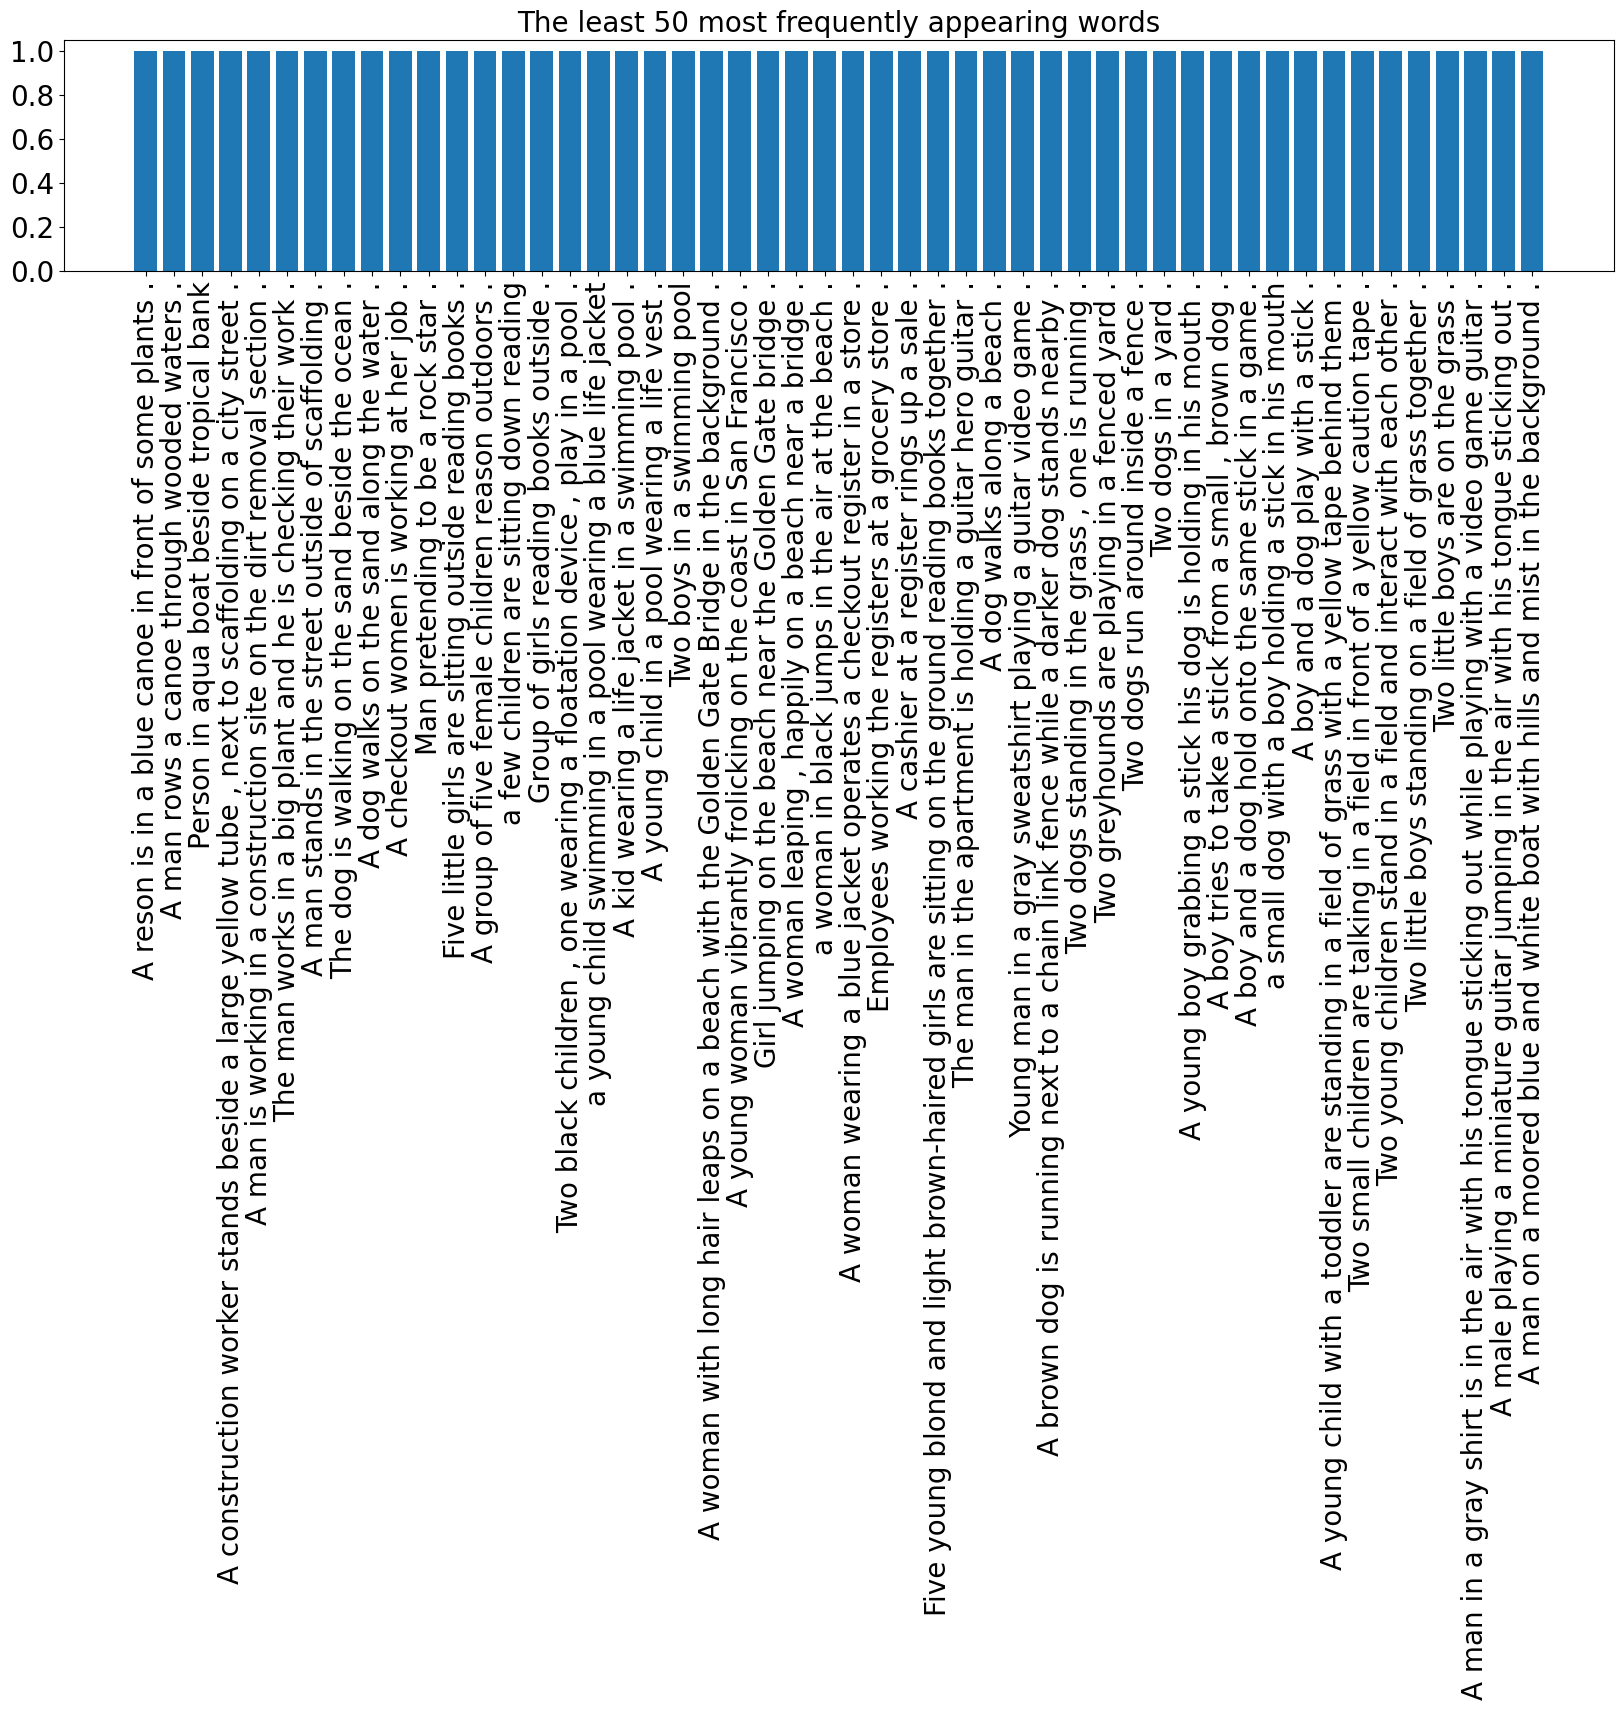

In [31]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [33]:
import string
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [41]:
import progressbar  # Ensure progressbar is imported

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return text

# Create a ProgressBar instance
bar = progressbar.ProgressBar(maxval=len(df_txt.caption.values))
bar.start()  # Start the progress bar

for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption
    bar.update(i + 1)  # Update the progress bar

bar.finish()  # Finish the progress bar

# ... rest of your code ...


100% |########################################################################|


Vocabulary Size: 54


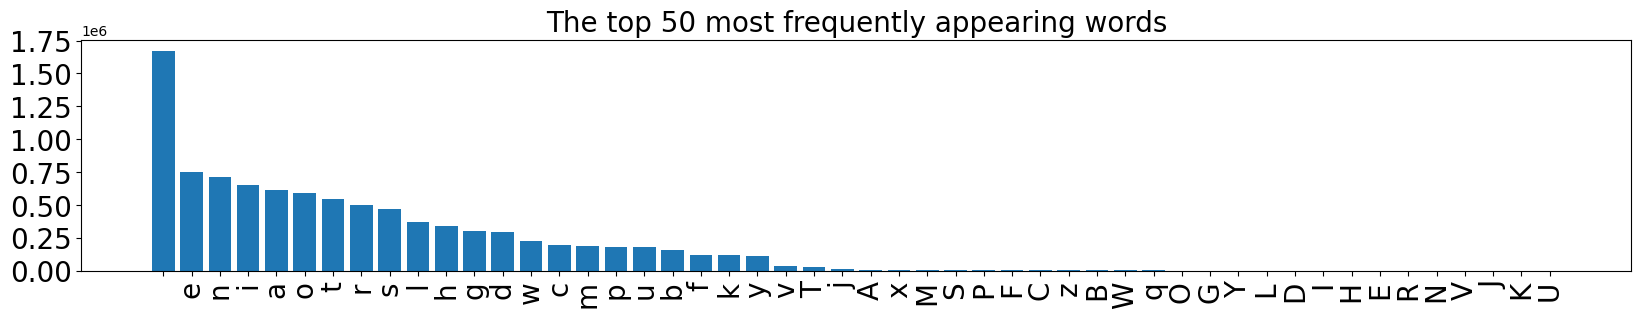

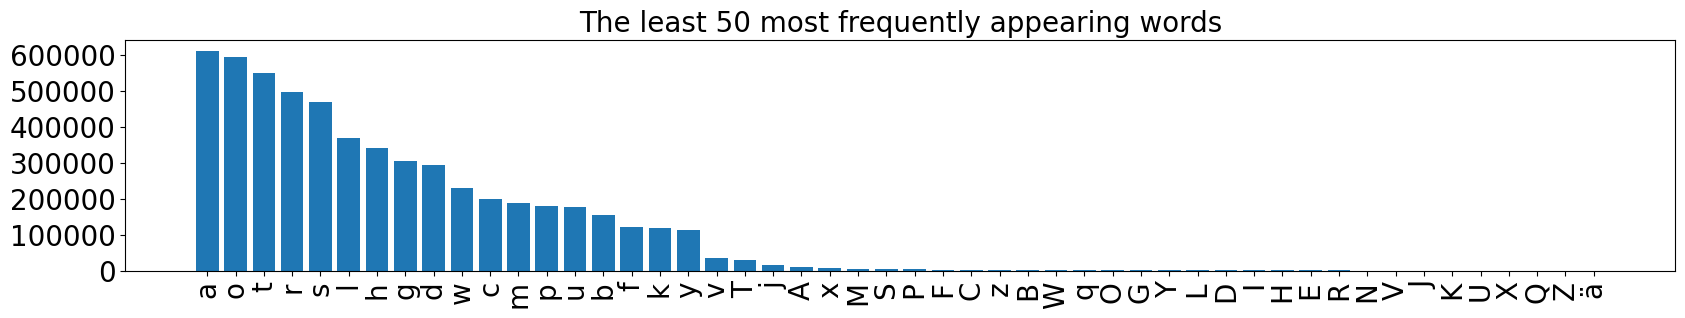

In [42]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [43]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [46]:
from keras.applications import VGG16

modelvgg = VGG16(include_top=True,weights=None)
## load the locally saved weights 
modelvgg.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels.h5')
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [47]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [56]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224
target_size = (npix, npix, 3)

# Assuming you have already imported the progressbar library
bar = progressbar.ProgressBar(maxval=len(jpgs))
bar.start()

for i, name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    y_pred = modelvgg.predict(nimage.reshape((1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()
    bar.update(i + 1)

bar.finish()


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 182ms/step


1/1 [==============================] - 0s 190ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 209ms/step


1/1 [==============================] - 0s 215ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 195ms/step


1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 202ms/step


1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 208ms/step


1/1 [==============================] - 0s 207ms/step


1/1 [==============================] - 0s 230ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 201ms/step


1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 233ms/step


1/1 [==============================] - 0s 190ms/step


1/1 [==============================] - 0s 222ms/step


1/1 [==============================] - 0s 201ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 201ms/step


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 214ms/step


1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 205ms/step


1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 226ms/step


1/1 [==============================] - 0s 192ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 200ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 193ms/step


1/1 [==============================] - 0s 228ms/step


1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 194ms/step


1/1 [==============================] - 0s 190ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 190ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 191ms/step


1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 203ms/step


1/1 [==============================] - 0s 194ms/step


1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 161ms/step


1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 223ms/step


In [ ]:
dimages, keepindex = [],[]
nd=(df_txt0["index"].values)
b = [(int(i)==0) for i in nd]
#for i in nd:
 #   print(int(i)==0)
#df_txt0 = df_txt0.loc[b,: ]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]

for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)
print(df_txt0["index"][:5])

In [ ]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
count_words=22000
#nb_words = 31782
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

In [ ]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [ ]:
maxlen = np.max([len(text) for text in dtexts])

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

In [ ]:
from keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

In [ ]:
start = time.time()
#checkpoint_path = "training_1/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
#cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
 #                                                save_weights_only=True,
  #                                               verbose=2)

hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=7, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
                #callbacks = [cp_callback])
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

In [ ]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

In [ ]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))